(labs:cor61)=
# Denoising

<hr>

## 📌 Commentaires pour les intervenants

- L'année dernière, les étudiants n'ont abordé que le débruitage.
  Le déconvolution ne sera donc abordée que par les étudiants les plus rapides.
  Ce n'est pas grave, d'autant plus que l'exercice sur la déconvolution est similaire à celui sur le débruitage.
- il me semble important que les étudiants sachent simuler une observation, c'est-à-dire générer le modèle direct.
  En effet, c'est une manière classique de produire des données et la solution recherchée.
  C'est pour cela que les premières questions, loin d'être anodines, leur demande de générer une image bruitée ou floutée.
- La correction que je propose ci-dessous est très complète : je n'attends pas autant des étudiants.
- Il faut continuer à pousser les étudiants à développer leur esprit critique.
  Cela commence par faire une bonne observation des résultats obtenus, à faire une interprétation correcte,
  à proposer des solutions pour améliorer la méthode où pour aller plus loin dans la compréhension du problème,
  et enfin à proposer de nouvelles expériences pour vérifier les hypothèses émises.
  
<hr>

The objectives of this exercise are:
* to apply a white Gaussian noise with a specific SNR on an image
* to implement a denoising method
* to understand the effects of the parameters and set it accordingly to the epexpected solution

Two denoising methods are considered in this correction: the mean filter and TV regularization.

In [1]:
from scipy.ndimage import convolve

from numpy import sqrt, ones, zeros, arange, argmin, array, inf, linspace
from numpy.linalg import norm

from skimage.io import imread
from skimage.util import random_noise
from skimage.color import rgb2gray
from skimage.metrics import mean_squared_error
from skimage.restoration import denoise_tv_chambolle

from matplotlib.pyplot import imshow, figure, subplot, title, plot, xlabel, ylabel, ylim, show, xticks, yticks, grid
from matplotlib.pyplot import semilogy, legend

In [2]:
# Calcul de la variance d'un bruit blanc gaussien pour un RSB donné
def variance(snr, x):
    M, N = x.shape
    return norm(x)**2 / (M*N) * 10**(-snr/10)

## Original image and noisy image

The original image:

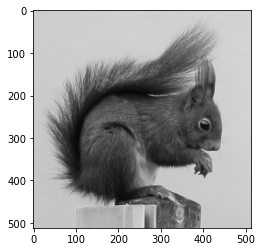

In [3]:
x = imread("squirrel.png")
x = x.astype(float)
M, N = x.shape
imshow(x, cmap="gray");

The signal-to-noise ratio (SNR) is defined as the power of the image $x$ divided by the power of the noise $b$.
Besides, it is generally given with a logarithmic scale.

$$
\mathrm{SNR} = 10 \log_{10} \left(\frac{P_x}{P_b}\right)
\quad\Leftrightarrow\quad
10^\frac{\mathrm{SNR}}{10} = \frac{P_x}{P_b}
$$

where:

$$
Px = \frac{1}{MN} \sum_{m,n} x(m,n)^2
\quad\text{et}\quad
Pb = \frac{1}{MN} \sum_{m,n} b(m,n)^2 = \sigma^2
$$

Then:

$$
                     &P_b = \frac{P_x}{10^\frac{\mathrm{SNR}}{10}} \\
\Leftrightarrow\quad &\sigma^2 = P_x \times 10^{-\frac{\mathrm{SNR}}{10}} \\
\Leftrightarrow\quad &\sigma^2 = \frac{1}{MN} \sum_{m,n} x(m,n)^2 10^{-\frac{\mathrm{SNR}}{10}} \\
$$

Note that $\sqrt{\sum_{m,n} x(m,n)^2} $ corresponds to the Frobenius norm of $x$ and can be calculated with `numpy.linalg.norm`.

The figures below represent the image at different noise levels.

**Warning:** do not forget `clip=False` when using `skimage.util.random_noise`, in order to add a true Gaussian noise!

23.0 213.0
-2201.4086009119915 2275.6137247051365
23.0 213.0
-539.5441760226183 793.2017908525348
23.0 213.0
-161.18279009761866 382.7151133738539
23.0 213.0
-17.39143319852075 249.57106653935236
23.0 213.0
12.994998976891438 219.12697502227738


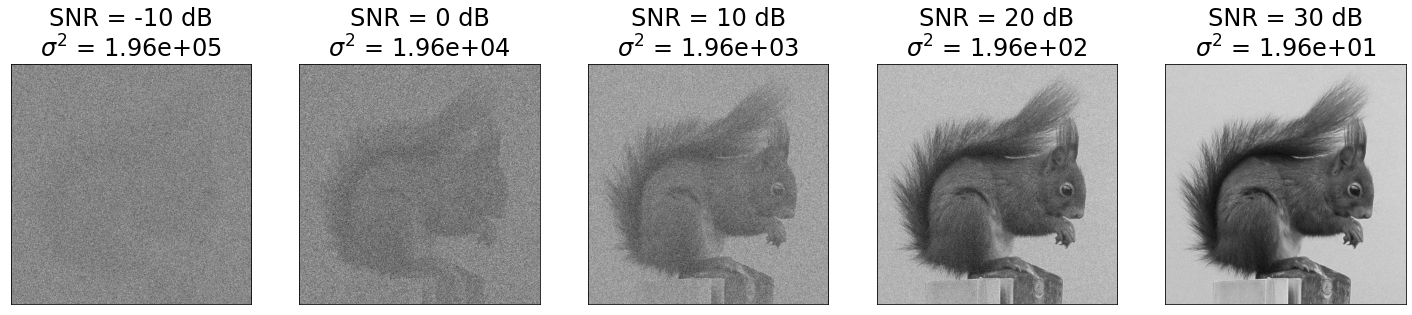

In [4]:
rsbs = [-10, 0, 10, 20, 30]

figure(figsize=(25,10))
i = 0

for rsb in rsbs:
    var = variance(rsb, x)
    y = random_noise(x, mode='gaussian', clip=False, var=var)
    print(x.min(), x.max())
    print(y.min(), y.max())
    i = i + 1
    subplot(1,5,i)
    imshow(y, cmap="gray")
    xticks([])
    yticks([])
    title(f"SNR = {rsb:.0f} dB\n$\sigma^2$ = {var:.2e}", fontsize=24)

Note that the larger the SNR, the less visible the noise.
This makes sense since, in the definition of SNR, the noise power is in the denominator.
In addition, the noise becomes almost invisible beyond 30 dB, while it is very high and the image is hardly visible below 0 dB.

## Mean filter

I choose the image whose SNR equals 10 dB, and I apply a mean filter.

In [5]:
snr = 10
var = variance(snr, x)
y = random_noise(x, mode='gaussian', clip=False, var=var)

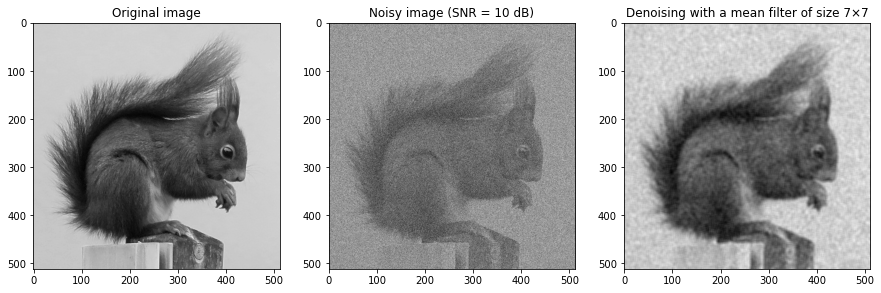

In [6]:
# Exemple d'un filtre moyenneur pour une taille particulière
w = 7
h = ones((w,w)) / (w*w)
xest_mean = convolve(y, h)

# Affichage
figure(figsize=(15,5))
subplot(1,3,1)
imshow(x, cmap="gray")
title("Original image")
subplot(1,3,2)
imshow(y, cmap="gray")
title(f"Noisy image (SNR = {snr} dB)")
subplot(1,3,3)
imshow(xest_mean, cmap="gray")
title(f"Denoising with a mean filter of size {w}×{w}");

We observe that the mean filter reduces the noise, which is expected (have you tried a filter of size 1×1? What's going on?).
On the other hand, the image is more blurry: the contours are less sharp.
This second observation is explained by the fact that the mean filter is a convolution by a kernel which is not a single pulse:
so the intensities of the pixels spreads over their neighbourhood.

The mean squared error is an objective measure of the quality of the restoration.
It is calculated between the denoised image $\hat{x}$ and the original one $x$.
Therefore, the mean filter helps to decrease the MSE by reducing the noise.
But at the same time it increases the MSE by introducing blur in the image.
As a consequence, the MSE evolves with the size $w \times w$ of the filter.
To verify this hypothesis, we plot the values of the MSE with respect to $w$:

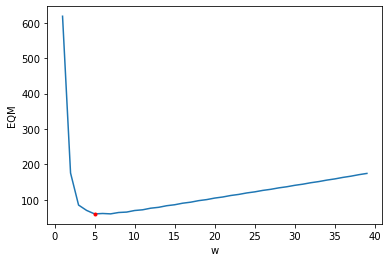

In [15]:
# Évolution de l'EQM en fonction de la taille du filtre
ws = arange(1,40)
mses = zeros(ws.shape)
for i, w in enumerate(ws):
    h = ones((w,w)) / (w*w)
    xest = convolve(y, h)
    mses[i] = mean_squared_error(x, xest)
i = argmin(mses)
mse = mses[i]
w = ws[i]

plot(ws, mses)
plot(w, mse, 'r.')
xlabel('w')
ylabel('EQM')
show()

As expected, the MSE change with respect of the filter size.
A compromise must be made between the noise reduction and the blurring.
We observe that the curve has a minimum, it corresponds to the best choice for $w$ (in terms of MSE).

In [8]:
print(f"The best restoration is obtained for w = {w:.0f} and get an MSE = {mse:.2e}")

The best restoration is obtained for w = 9 and get an MSE = 8.35e+01


Unfortunately, there is no easy way to know a priori the best size of the mean filter just knowing the SNR.
The value obtained here depends on the image (try with another image!).

## TV denoising

With the noisy image at SNR = 10 dB, we now carry out a denoising by TV regularization.

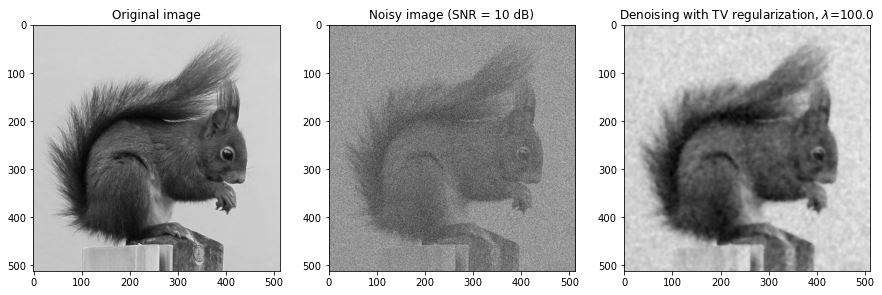

In [9]:
# Exemple
lbd = 1e2
xest_tv = denoise_tv_chambolle(y, weight=lbd)

# Affichage
figure(figsize=(15,5))
subplot(1,3,1)
imshow(x, cmap="gray")
title("Original image")
subplot(1,3,2)
imshow(y, cmap="gray")
title(f"Noisy image (SNR = {snr} dB)")
subplot(1,3,3)
imshow(xest_tv, cmap="gray")
title(f"Denoising with TV regularization, $\lambda$={lbd}");

As with the mean filter, we observe that the image is partially denoised (therefore the MSE will be better),
but, again, the contours are less sharp, resulting in a degradation of the MSE.
As previously, it should exist an optimal value of the regularization parameter $\lambda$.
Let's see if this denoising technique can surpass the mean filter...

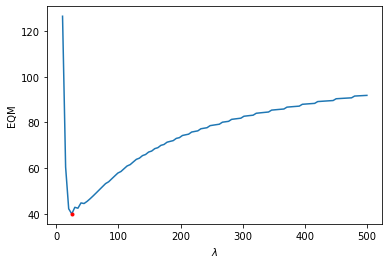

The best restoration is obtained for lambda = 25 and get an MSE = 4.01e+01


In [16]:
# Évolution de l'EQM en fonction de la taille du filtre
lbds = linspace(10, 500, 100)
mses = zeros(lbds.shape)
for i, lbd in enumerate(lbds):
    xest = denoise_tv_chambolle(y, weight=lbd)
    mses[i] = mean_squared_error(x, xest)
i = argmin(mses)
mse = mses[i]
lbd = lbds[i]

plot(lbds, mses)
plot(lbd, mse, 'r.')
xlabel('$\lambda$')
ylabel('EQM')
show()

print(f"The best restoration is obtained for lambda = {lbd:.0f} and get an MSE = {mse:.2e}")

The curve has the same behavior as in the case of the mean filter:
there is an optimal value of the regularization parameter for which the MSE is the best.
Moreover, we notice that the best MSE is lower than the best MSE obtained with the mean filter.
So we want to conclude that TV regularization is more efficient than the mean filter!
But beware: this conclusion is partial, because it was only obtained on _one_ image with _one_ SNR.

## Comparison of the two denoising methods for different SNRs

It is possible to analyze the evolution of the MSE with respect to the noise level by calculating, for several values of SNR,
the best parameters for the two methods.

In [11]:
rsbs = arange(-5, 20, 2)

# Filtre moyenneur
ws = arange(1,40)
mean_eqm = zeros(rsbs.shape)
mean_w = zeros(rsbs.shape)

# Régularisation TV
lbds = linspace(0, 200, 20)
tv_eqm = zeros(rsbs.shape)
tv_lbd = zeros(rsbs.shape)

for i, rsb in enumerate(rsbs):
    
    # Génération de l'image bruitée
    var = variance(rsb, x)
    y = random_noise(x, mode='gaussian', clip=False, var=var)

    # Filtre moyenneur
    besteqm = inf
    for w in ws:
        h = ones((w,w)) / (w*w)
        xest = convolve(y, h)
        eqm = mean_squared_error(x, xest)
        if eqm < besteqm:
            besteqm = eqm
            bestw = w
    mean_eqm[i] = besteqm
    mean_w[i] = bestw
    
    # Débruitage TV
    besteqm = inf
    for lbd in lbds:
        xest = denoise_tv_chambolle(y, weight=lbd)
        eqm = mean_squared_error(x, xest)
        if eqm < besteqm:
            besteqm = eqm
            bestlbd = lbd
    tv_eqm[i] = besteqm
    tv_lbd[i] = bestlbd

/home/vincent/anaconda3/lib/python3.9/site-packages/skimage/restoration/_denoise.py:379: RuntimeWarning: divide by zero encountered in double_scalars
  norm *= tau / weight
/home/vincent/anaconda3/lib/python3.9/site-packages/skimage/restoration/_denoise.py:379: RuntimeWarning: invalid value encountered in multiply
  norm *= tau / weight


Then we can represent the evolution of the MSE for the two methods:

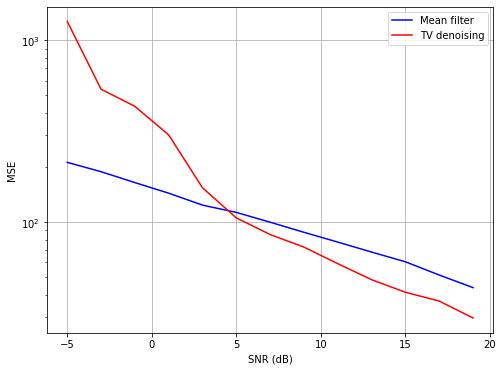

In [20]:
figure(figsize=(8,6))
semilogy(rsbs, mean_eqm, 'b', label='Mean filter')
semilogy(rsbs, tv_eqm, 'r', label='TV denoising')
# ylim(0, 1e4)
legend()
grid()
xlabel("SNR (dB)")
ylabel("MSE");

We observe that the MSE decreases with the SNR.
The interpretation is easy:
the more the noise decreases, the more the image resembles the original image, and therefore denoising is less difficult.

In addition, we observe that:
* for SNRs lower than (approximately) 5 dB, the mean filter is better than TV regularization.
  This seems surprising since the TV regularization is supposed to be better.
  However, an SNR lower than 5 dB is extremely low.
  In fact, neither of the two methods gives a really satisfactory result (see below).
* for images with SNR greater than 5 dB, TV regularization is better.

Let's see on some examples:

<!-- Let us now observe the evolution of the values of the best parameters of the two methods, according to the SNR: -->

In [13]:
# figure(figsize=(9,3))
# subplot(1,2,1)
# plot(rsbs, mean_w, 'b')
# xlabel("SNR (dB)");
# ylabel('Mean filter size')
# title("Mean filter")
# subplot(1,2,2)
# plot(rsbs, tv_lbd, 'r')
# xlabel("SNR (dB)")
# ylabel('Parameter $\lambda$')
# title("TV regularization")
# show()

<!-- Pour les deux méthodes, la valeur du paramètre décroît lorsque le RSB augmente.
* pour le filtre moyenneur (en bleu), la fenêtre utilisée est donc de plus en plus petite lorsque le bruit diminue. C'est logique : le bruit diminuant, il n'est pas nécessaire de moyenner sur un grand voisinage, ce qui permet de trop flouter l'image.
* pour la régularisation TV (rouge), le paramètre de régularisation est plus faible lorsque le bruit diminue. C'est également logique : en diminuant, le paramètre de régularisation donne moins de poids à la régularisation qui est là surtout pour compenser le bruit. S'il y a moins de bruit, il y a moins besoin de régulariser !

On peut vérifier que ces conclusions sont en accord avec ce qu'on peut observer sur quelques exemples : -->

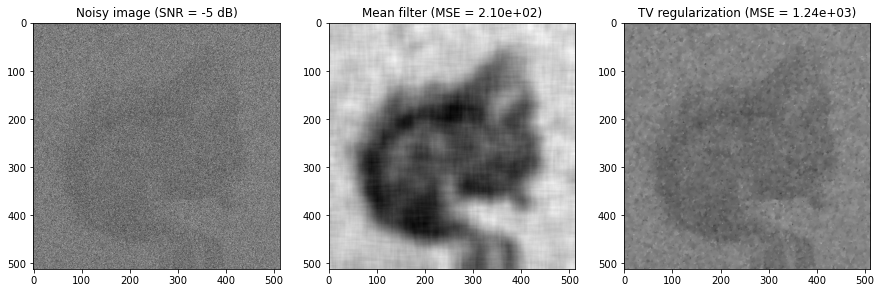

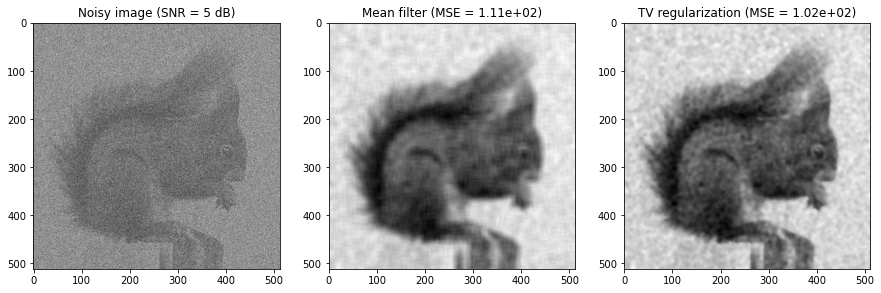

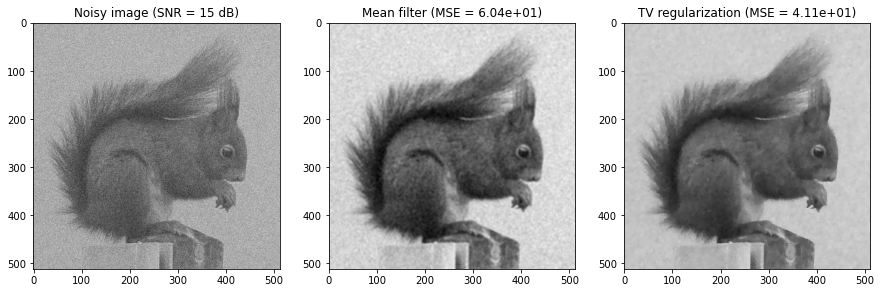

In [14]:
idx = [0, 5, 10]

for i in idx:
    
    rsb = rsbs[i]
    
    # Génération de l'image bruitée
    var = variance(rsb, x)
    y = random_noise(x, mode='gaussian', clip=False, var=var)

    # Filtre moyenneur
    w = int(mean_w[i])
    h = ones((w,w)) / (w*w)
    xest_mean = convolve(y, h)
    eqm_mean = mean_squared_error(x, xest_mean)
    
    # Débruitage TV
    lbd = tv_lbd[i]
    xest_tv = denoise_tv_chambolle(y, weight=lbd)
    eqm_tv = mean_squared_error(x, xest_tv)
    
    # Affichage
    figure(figsize=(15,15))
    subplot(1,3,1)
    imshow(y, cmap="gray")
    title(f"Noisy image (SNR = {rsb} dB)")
    subplot(1,3,2)
    imshow(xest_mean, cmap="gray")
    title(f"Mean filter (MSE = {eqm_mean:.2e})")
    subplot(1,3,3)
    imshow(xest_tv, cmap="gray")
    title(f"TV regularization (MSE = {eqm_tv:.2e})")

OK, we have the same conclusions as before.

The comparison between the two methods was only carried out on a single image and a single criterion (the MSE).
This is undoubtedly a good criterion for comparing two methods, but other criterions exist,
such as for example the complexity of the method, the computation time, etc.